## Import required libraries.

In [11]:
%%capture
import operator
import seaborn as sns; sns.set()
from jupyterthemes import jtplot
jtplot.style()
import numpy as np
from landlab import FieldError
from landlab.utils import get_watershed_mask
import xarray as xr
import pandas as pd
import scipy
import gdal
from scipy import ndimage
from scipy.ndimage.filters import *
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.signal import medfilt
import os
import math
from osgeo import osr
from fractions import Fraction
import timeit
import matplotlib.pyplot as plt
#import matplotlib.image as mpimg
%matplotlib inline
import random
# import plotting tools
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib as mpl
from landlab.plot.imshow import imshow_grid 

# import necessary landlab components
from landlab import RasterModelGrid, HexModelGrid
from landlab.components import FlowAccumulator, FlowRouter, LakeMapperBarnes, SinkFillerBarnes
from landlab.components import(FlowDirectorD8, 
                               FlowDirectorDINF, 
                               FlowDirectorMFD, 
                               FlowDirectorSteepest)
from landlab.components import DepressionFinderAndRouter
# import landlab plotting functionality
from landlab.plot.drainage_plot import drainage_plot
from pylab import show, figure

# create a plotting routine to make a 3d plot of our surface. 
def surf_plot(mg, surface='topographic__elevation', 
              title='Surface plot of topography', colormap = cm.gray):
    
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    # Plot the surface.
    Z = (mg.at_node[surface].reshape(mg.shape))#[y1:y2, x1:x2]
    color = colormap((Z-Z.min())/(Z.max()-Z.min()))
    surf = ax.plot_surface(mg.node_x.reshape(mg.shape),#[y1:y2, x1:x2]
                           mg.node_y.reshape(mg.shape),#[y1:y2, x1:x2]
                           Z,
                           rstride=1, cstride=1,
                           facecolors=color,
                           linewidth=0.,
                           antialiased=False)
    ax.view_init(elev=35, azim=-120)
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Elevation')
    plt.title(title)
    plt.show()

## Setup input data 
Define spatial resolution: Specify the resolution of the input DEM and also the desired working resolution (can be same as input DEM resolution).

In [12]:
input_DEM_resolution = 0.5
working_resolution = 0.5
location = (r'C:\PhD\alluvial_fans\gully_heads\fann_0\convergence_points')
os.chdir(location)
input_geotiff = gdal.Open('af_1_dem.tif')
x = np.array(input_geotiff.GetRasterBand(1).ReadAsArray())
input_DEM = scipy.ndimage.zoom(x, input_DEM_resolution / working_resolution, order = 1)

input_outlets = gdal.Open('af1_g2.tif')
o = np.array(input_outlets.GetRasterBand(1).ReadAsArray())
outlets = 1 - o

## Visualise the DEM.

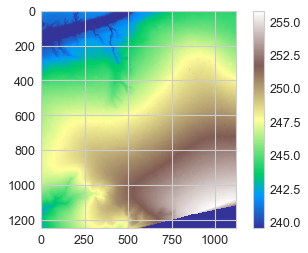

In [13]:
plt.imshow(input_DEM, cmap="terrain", vmin = np.percentile(input_DEM, 5));
plt.colorbar();

## Define required function.

In [127]:
def rectangleWindow(m, n):
    """Takes a value for number of rows (m) and number of columns (n) such that
       m and n are both positive real numbers and creates a rectangle of 
       boolian 'True' values."""
    rectangle = np.ones((m, n), dtype=bool) 
    return rectangle
def number_of_values(Window):
    """This funciton takes the shape function as an input and returns a number 
        of values present in the specified shape. 
        
        This can be different for a different window shape and to initialize
        requires the specification of the function for the given window type and 
        parameter values required for that input function.
        
        To initialize this function for shape == rectangle type 'number_of_values(rectangleWindow(m,n)) 
        where m and n are any positive real number as per the rectangleWindow function."""
    denominator = sum(sum(Window > 0))
    return denominator
def circleWindow(radius):
    """Takes a value for radius (r where r is any positive real number) and creates 
       a circular window using that radius."""
    y, x = np.ogrid[-radius: radius + 1, -radius: radius + 1]
    circle = x**2 + y**2 <= radius**2
    return circle
def find_median_value(Window):
    """This function takes the shape function and returns the median value 
        for all valid values (values that fall in the circle) arranged into a 
        1d array. The function also takes the number_of_values function as an input.
        To execute this function type 'find_median_value(shape(r)) where r is any integer.
        #Note: using median like this only gives the correct value for circles with odd 
        radius values."""
    no_values = number_of_values(Window)
    value_range = np.arange(0, no_values + 1)
    central_value = int(np.median(value_range))
    return central_value
def difference_from_mean_elevation(elev):
    """This function only works as an inside function to generic_filter function below. This
       is because generic_filter will take a 2d array and reshape it into a 1d array. Without this 
       step the 'central_value' variable will be outside of the array dimensions. 
       x = input DEM and r = radius of search window """
    centroid = elev[central_value]                        
    mean = np.nanmean(elev)#Count number of values greater than centroid value
    diff = centroid - mean
    return diff
def PCTL(x):
    """This function only works as an inside function to generic_filter function below. This
       is because generic_filter will take a 2d array and reshape it into a 1d array. Without this 
       step the 'central_value' variable will be outside of the array dimensions. 
       x = input DEM and r = radius of search window """
    centroid = x[central_value]                        
    y = np.sum(x < centroid)/num_values#Count number of values greater than centroid value
    return y
def flow_dir_dataset(flow_rec_prop, catchment_area, grid_resolution, outlet_node):
    """ Create an xarray Dataset containing eight arrays each representing the
    amount of water flowing in the given direction.
        1 . flow_rec_prop == the flow receiver proportion array created by LandLab flow routing.
        2 . catchment_area == the corresponding catchment area array from the landLab flow accumulation.
        surface.        
    The resulting Dataset is used to calculate specific catchment area."""
    array_direction = xr.Dataset()
    for i in range(0,8):
        rows = catchment_area.shape[0]; cols = catchment_area.shape[1];
        direction = np.flip(flow_rec_prop[:,i].reshape(rows,cols), 0);
        # Above needs to be flipped because during reshape it organises data top down
        # rather than bottom up as per ModelGrid order (catchment_area is mg arrangement).
        zero_outlet = outlet_node != 1
        remove_outlet = zero_outlet * catchment_area
        weighted_direction = xr.DataArray((remove_outlet * direction),
                                          dims = ['lat', 'lon']);
        array_direction[direction_list[i]] = weighted_direction
        
    E, N, W, S, NE, NW, SW, SE = (array_direction['East'], array_direction['North'],
                             array_direction['West'], array_direction['South'],
                             array_direction['North East'], array_direction['North West'],
                             array_direction['South West'], array_direction['South East'])

    flow_dirs = xr.concat([E, N, W, S, NE, NW, SW, SE], 'direction')
    flow_dirs.name = 'flow_directions'
    flow_dirs.attrs['grid cell resolution'] = grid_resolution
    flow_directions = flow_dirs.assign_coords(direction=(['East','North','West','South',
                                   'North East', 'North West','South West', 'South East']))
    return flow_directions
def profileCurvature(DEM, cellsize):
    """This process is taken from Change (2014, Introduction to Geographic Information
       systems, Page 284)."""
    Z1 = DEM[0]; Z2 = DEM[1]; Z3 = DEM[2]
    Z4 = DEM[3]; Z0 = DEM[4]; Z5 = DEM[5]
    Z6 = DEM[6]; Z7 = DEM[7]; Z8 = DEM[8]
    D = (((Z4 + Z5)/2) - Z0) / cellsize**2
    E = (((Z2 + Z7)/2) - Z0) / cellsize**2
    F = (Z3 - Z1 + Z6 - Z8)/ (4 * cellsize**2)
    G = (Z5 - Z4) / (2 * cellsize)
    H = (Z2 - Z7) / (2 * cellsize)
    profile_curvature = (-2 * (D*(G**2) + E*(H**2) + (F*G*H))) / (G**2 + H**2)
    return profile_curvature
def slopeWindowDegrees(DEM, x_cellsize, y_cellsize):
    """This function implements slope calculation using the same algorithm
       as ARCGIS (Outlined on the page 'How Slope Works').
       This particular example of the function is written such that it
       will only work if called within the ndimage generic_filter (as the first input).
       This is because the index arguments for a-e are given for the 1d array created
       by the generic_filter function after extracting values from the 3,3 rectangle window.
       NOTE: THIS FUNCTION ONLY WORKS WITH A 3x3 RECTANGLE WINDOW."""
    a = DEM[0]; b = DEM[1]; c = DEM[2]
    d = DEM[3]; e = DEM[4]; f = DEM[5]
    g = DEM[6]; h = DEM[7]; i = DEM[8]
    dzdx = ((c + (2*f) + i) - (a + (2*d) + g)) / (8 * x_cellsize)
    dzdy = ((g + (2*h) + i) - (a + (2*b) + c)) / (8 * y_cellsize)
    rise_run = np.sqrt(dzdx**2 + dzdy**2)
    slope_degrees = np.arctan(rise_run) * (180/math.pi)
    slope_percent = rise_run * 100
    #Can also ask it to return slope_degrees but asking for both causes it to throw and error.
    return slope_degrees
def closest(lst, K): 
     angle_list = lst
     idx = (np.abs(angle_list - K)).argmin() 
     return angle_list[idx] 

## Setup a RasterModelGrid object and assign elevation to nodes.

In [15]:
catchment_area_grids = xr.Dataset()
direction_list = ['East', 'North', 'West', 'South',
                  'North East', 'North West', 'South West', 'South East'];
#################################################################################################
flow_acc_surf = np.copy(input_DEM).astype('float64');
#################################################################################################
rows = flow_acc_surf.shape[0];
cols = flow_acc_surf.shape[1];
mg = RasterModelGrid((rows,cols), 1);
z1 = mg.add_field('topographic__elevation', flow_acc_surf, at = 'node');

## Find the node ID of the outlet.
Note: Outlet spatial location is given by the 'outlets' variable assigned under "Setup input data."

In [16]:
grid_nodes = np.array(mg.nodes.reshape(mg.shape))
find_outlet_ids = grid_nodes * outlets
outlet_id = np.unique(find_outlet_ids)[1]
outlet_id

333971

## Fill sinks and run flow accumulation.

In [17]:
sfb = SinkFillerBarnes(mg, method = 'Steepest', ignore_overfill = True);
sfb.run_one_step();
fa = FlowAccumulator(mg,
                    surface = 'topographic__elevation',
                    flow_director = 'FlowDirectorMFD',
                    diagonals = True);
#(flow_acc, q) = fa.accumulate_flow();
fa.run_one_step()
fd = FlowDirectorMFD(mg, 'topographic__elevation', diagonals = True);
fd.run_one_step()

## Show a list of values located on each node.

In [18]:
mg.at_node.keys()

dict_keys(['topographic__elevation', 'sediment_fill__depth', 'water__unit_flux_in', 'flow__sink_flag', 'flow__receiver_node', 'topographic__steepest_slope', 'flow__link_to_receiver_node', 'flow__receiver_proportions', 'drainage_area', 'surface_water__discharge', 'flow__upstream_node_order', 'flow__data_structure_delta'])

## Assign some of the above values to variables.

In [19]:
da = np.array(mg.at_node['drainage_area'].round(4));
catchment_area_ha = np.divide(da.reshape(mg.shape), (100/working_resolution)**2)
frn = mg.at_node['flow__receiver_node'];
drainage_area = np.flip(da.reshape(mg.shape), 0);
wuf = np.array(mg.at_node['water__unit_flux_in']);
frp = np.array(mg.at_node['flow__receiver_proportions']);
funo = np.array(mg.at_node['flow__upstream_node_order'].reshape(mg.shape));
ns = np.flip(mg.status_at_node.reshape(mg.shape), 0);
flow_rec_surf_rows = cols * rows;
flow_rec_surf = frp.reshape(flow_rec_surf_rows,8);
flrn = mg.at_node['flow__link_to_receiver_node'];
links_carrying_flow = flrn.reshape(flow_rec_surf_rows,8);
tss = mg.at_node['topographic__steepest_slope'];
steepest_slope = tss.reshape(flow_rec_surf_rows,8);
all_receiver_proportions = np.copy(frp);
flow_dir_da = flow_dir_dataset(all_receiver_proportions, drainage_area, 1, ns);
catchment_area_grids['flow_direction_grids' + '1' + '1'] = flow_dir_da;

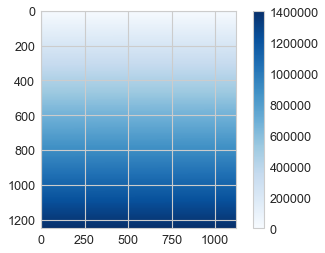

In [20]:
plt.imshow(grid_nodes, cmap="Blues");
plt.colorbar();

For each flow direction (given by the second index position of the flow__receiver_node object) find the rows (where each row is a single grid cell) that are contributing to a target grid cell. The target grid cell in the first instance will be the outlet node, and then the list of target grid cells will expand with every processing step.

In [21]:
start = timeit.default_timer()
# Specific the size of the area to be checked. This represents a physical distance from the 
# outlet but has no unit of measure.
distance_from_outlet = 50
# This value is used to initialise the search.
catchment_outlet_id = outlet_id
# Initate an outer loop that iterates through every distance interval from the outlet.
watershed_grid_cells = []
node_location = mg.nodes.reshape(da.shape)
ordered_node_list = []

for i in range(0, distance_from_outlet):
    # Create a list initially containing only the outlet grid cell.
    if i == 0:
        candidate_gridcells = [catchment_outlet_id];
    else:
        candidate_gridcells = list(set(upstream_nodes));
    # Empty the list of upsteam nodes.
    upstream_nodes = {};
    # Intiate a new loop to check every gridcell at the current interval distance.
    print(candidate_gridcells)
    for grid_cell in candidate_gridcells:
        print('grid cell', grid_cell)
        # Check each flow direction of the current grid cell.The second dimension of the 
        # flow__receiver_node object will always be size == 8.
        for i in range(frn.shape[1]):
            # Return all rows (grid nodes) that send any flow to the target grid cell.
            # Note: This can only be one grid cell because the prgram is looping through
            # each direction one at a time so only one grid cell can be sending flow from any
            # one given direction.
            flow_from_whole_grid_cell = frn[np.where(frn[:,i] == grid_cell)];
            # Check if the current direction contributes flow. If not, do nothing. 
            # Else, append to list.
            if flow_from_whole_grid_cell.shape[0] == 0:
                pass
            else:
                # Below variable finds the row position of the flow_from_direction gridcell
                # in the flow__receiver_node array. This corresponds to the contributing
                # cell's node id.
                node_id_value = np.where(np.all(flow_from_whole_grid_cell==frn,axis=1))[0][0];
                #Find the proportion of flow leaving the donor node and heading toward 
                # the current grid cell.
                proportion_of_flow = frp[node_id_value, i]
                # Create a boolean array to use as mask on drainage area.
                isolate_candidate_grid_cells = np.isin(node_location, node_id_value)
                node_drainage_area = np.amax(np.multiply(isolate_candidate_grid_cells, da))
                node_directional_drainage_area = node_drainage_area * proportion_of_flow
                upstream_nodes.update({node_id_value:node_directional_drainage_area});
        if len(upstream_nodes) == 0:
            print ("dictionary empty")
        else:
            primary_flow_direction_id = max(upstream_nodes.items(), key=operator.itemgetter(1))[0]
            upstream_nodes = []
            upstream_nodes.append(primary_flow_direction_id);
            ordered_node_list.append(primary_flow_direction_id);
            watershed_grid_cells.append(primary_flow_direction_id)
                    
stop=timeit.default_timer()
time = stop - start
print('Time taken' + ' = ', time, 'seconds')

[333971]
grid cell 333971
[335094]
grid cell 335094
[336217]
grid cell 336217
[337341]
grid cell 337341
[338464]
grid cell 338464
[339587]
grid cell 339587
[340710]
grid cell 340710
[341832]
grid cell 341832
[341831]
grid cell 341831
[342953]
grid cell 342953
[344076]
grid cell 344076
[345198]
grid cell 345198
[346320]
grid cell 346320
[347443]
grid cell 347443
[348566]
grid cell 348566
[349688]
grid cell 349688
[350811]
grid cell 350811
[351934]
grid cell 351934
[353056]
grid cell 353056
[354180]
grid cell 354180
[354181]
grid cell 354181
[354182]
grid cell 354182
[355306]
grid cell 355306
[356428]
grid cell 356428
[357551]
grid cell 357551
[358674]
grid cell 358674
[359798]
grid cell 359798
[360921]
grid cell 360921
[362045]
grid cell 362045
[363169]
grid cell 363169
[364293]
grid cell 364293
[365416]
grid cell 365416
[366538]
grid cell 366538
[367660]
grid cell 367660
[368782]
grid cell 368782
[369905]
grid cell 369905
[371028]
grid cell 371028
[372151]
grid cell 372151
[373273]
gri

In [22]:
preliminary_width = np.isin(node_location,watershed_grid_cells)
flow_width = (preliminary_width * da).reshape(mg.shape)

In [23]:
flow_width[flow_width==0] = np.nan

In [24]:
flow_grid_nodes = (preliminary_width * da).reshape(mg.shape)

In [25]:
len(ordered_node_list)

50

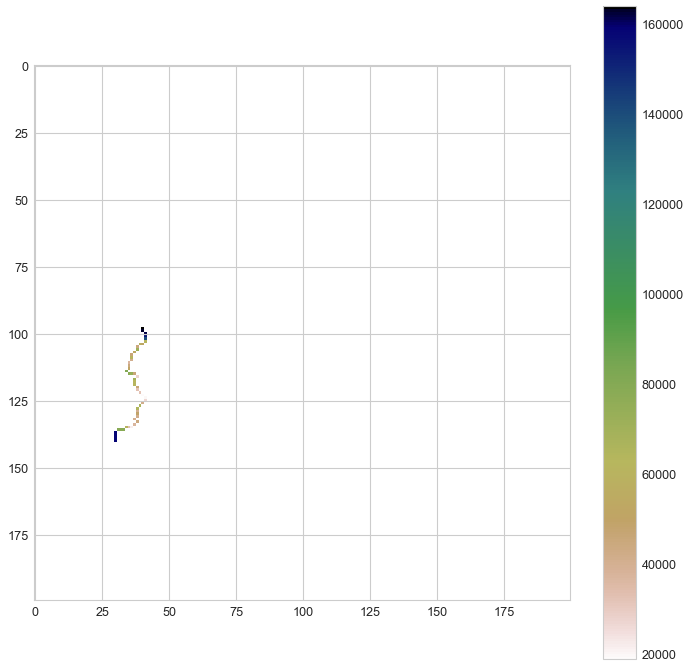

In [26]:
plt.figure(figsize=(12,12))
plt.imshow(flow_width[200:400, 400:600], cmap="gist_earth_r");
plt.colorbar();

In [27]:
drainage_mask = flow_width > 0

C:\Users\sjwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


In [28]:
central_value = find_median_value(circleWindow(5))
num_values = number_of_values(circleWindow(5))
DFME = generic_filter(input_DEM, difference_from_mean_elevation, 
                        footprint= circleWindow(5), mode='nearest');
DFME[DFME > 5.0] = 5.0
DFME[DFME < -5.0] = -5.0

In [29]:
slope = generic_filter(input_DEM, slopeWindowDegrees,
                  footprint= rectangleWindow(3,3),
                  mode='constant', extra_arguments = (input_DEM_resolution,input_DEM_resolution,));

In [30]:
profile_curvature = generic_filter(input_DEM, profileCurvature, 
                footprint= rectangleWindow(3,3), 
                mode='constant', extra_arguments = (input_DEM_resolution,));
profile_curvature[profile_curvature > 0.1] = 0.1
profile_curvature[profile_curvature < -0.1] = -0.1

C:\Users\sjwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:94: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\sjwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.
C:\Users\sjwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """


In [57]:
drainage_slope = np.multiply(drainage_mask, slope)

In [32]:
drainage_profile_curvature = np.multiply(drainage_mask, profile_curvature)

In [33]:
drainage_dfme = np.multiply(drainage_mask, DFME)

In [34]:
drainage_area = np.multiply(drainage_mask, catchment_area_ha)

In [35]:
drainage_nodes = np.multiply(drainage_mask, grid_nodes)

In [36]:
lat = grid_nodes.shape[0]
lon = grid_nodes.shape[1]
nodes_1d = np.squeeze(grid_nodes.reshape(1, lat * lon))
drainage_dfme_1d = np.squeeze(drainage_dfme.reshape(1, lat * lon))
drainage_slope_1d = np.squeeze(drainage_slope.reshape(1, lat * lon))
drainage_pc_1d = np.squeeze(drainage_profile_curvature.reshape(1, lat * lon))
drainage_area_1d = np.squeeze(drainage_area.reshape(1, lat * lon))
#drainage_dfme_1d_median = medfilt(np.squeeze(drainage_dfme.reshape(1, lat * lon)), 3)
#drainage_slope_1d_median = medfilt(np.squeeze(drainage_slope.reshape(1, lat * lon)), 3)
#drainage_pc_1d_median = medfilt(np.squeeze(drainage_profile_curvature.reshape(1, lat * lon)), 3)

In [37]:
node_drainage_dfme_dict = {}
for A, B in zip(nodes_1d, drainage_dfme_1d):
    node_drainage_dfme_dict[A] = B
    
dfme_from_gully_unordered = { key:value for key, value in node_drainage_dfme_dict.items() if value != 0 }

# This just reorders the dictionary to reflect the actual node order along the flow line.
# The step above creates a dictionary where the keys are ordered from highest to lowest and this is not always
# going to reflect the node order (only if the flow line is moving south to north).
dfme_from_gully = {k: dfme_from_gully_unordered[k] for k in ordered_node_list}

In [38]:
node_drainage_pc_dict = {}
for A, B in zip(nodes_1d, drainage_pc_1d):
    node_drainage_pc_dict[A] = B

pc_from_gully_unordered = { key:value for key, value in node_drainage_pc_dict.items() if value != 0 }
pc_from_gully = {k: pc_from_gully_unordered[k] for k in ordered_node_list}

In [39]:
node_drainage_slope_dict = {}
for A, B in zip(nodes_1d, drainage_slope_1d):
    node_drainage_slope_dict[A] = B

slope_from_gully_unordered = { key:value for key, value in node_drainage_slope_dict.items() if value != 0 }
slope_from_gully = {k: slope_from_gully_unordered[k] for k in ordered_node_list}

In [40]:
node_drainage_area_dict = {}
for A, B in zip(nodes_1d, drainage_area_1d):
    node_drainage_area_dict[A] = B

area_from_gully_unordered = { key:value for key, value in node_drainage_area_dict.items() if value != 0 }
area_from_gully = {k: area_from_gully_unordered[k] for k in ordered_node_list}

In [41]:
ds = [dfme_from_gully, pc_from_gully, slope_from_gully, area_from_gully]
d = {}
for k in dfme_from_gully.keys():
  d[k] = tuple(d[k] for d in ds)
d_ordered = {k: d[k] for k in ordered_node_list}

In [42]:
# Need to somehow replace node id with 0-n early on and then add the node list to the pandas array after.

In [43]:
drainage_parameters = pd.DataFrame.from_dict(d_ordered)

In [44]:
drainage_parameters.rename(index={0:'DFME',1:'PC', 2: 'Slope', 3: 'Area'}, inplace=True)

In [45]:
drainage_parameters_transpose = drainage_parameters.T

In [46]:
drainage_parameters_transpose.insert(0, "Distance", 0)

for i in range(0, distance_from_outlet):
    drainage_parameters_transpose.iloc[i,0] = i

In [47]:
drainage_parameters_transpose['Node ID'] = drainage_parameters_transpose.index

## Find the angle theta between CP and GH. 

        First find width of the array in the second dimension so that I can find the distance between the GH and CP by minusing the node values from each other. I think I should take the absolute value of this because all I need is H and L to find theta and it doesn't actally matter what the direction is. However, maybe by preserving direction it will hold potentially some seful information. So maybe use the scheme of negative or positive and explain why this is done instead of just taking the absolute value.

### First determine if it is north or south flowing.
Extract gully head and convergence point and subtract gully head from convergence point. Gully head is subtracted from convergence point because that returns negative values putting in place a convention that if water is flowing from south to north (opposite) the value will be negative, but if it flows for north to south (normal) it will be positive. 

In [48]:
algorithm_end_point = drainage_parameters_transpose['Distance'].max()
algorithm_start_point = drainage_parameters_transpose['Distance'].min()

### Gully head

In [49]:
gh = drainage_parameters_transpose.loc[drainage_parameters_transpose['Distance'] == algorithm_end_point,
                                                  'Node ID'].values[0]

### Convergence point

In [50]:
cp = drainage_parameters_transpose.loc[drainage_parameters_transpose['Distance'] == algorithm_start_point,
                                                  'Node ID'].values[0]

### Distance between convergence point and gully head

In [62]:
node_length = np.abs(cp - gh)
length = node_length/mg.shape[0]

## Find orientation

First isolate the graph quadrant the gully head is in. This uses the convention that the convergence point is always at the origin of a coordinate system.

Always subtract gully head from convergence point for latitude (so that values are positive above the x-axis.

Always subtract convergence point from gully head for longitude (so that values are positive to the right of the y-axis).

This keeps the system consistent with a standard 2D Cartesian plane.

Latitude = CP-GH; index position == 0

Longitude = GH - CP; index position == 1 

Quadrant 1 - upper left: CP-GH (+), GH-CP (-)  

Quadrant 2 - upper right:  CP-GH (+), GH-CP (+)  

Quadrant 3 - lower left:  CP-GH (-), GH-CP (-)  

Quadrant 4 - lower right:  CP-GH (-), GH-CP (+)  

In [80]:
gh_lat = np.where(grid_nodes == gh)[0][0]
cp_lat = np.where(grid_nodes == cp)[0][0]
gh_lon = np.where(grid_nodes == gh)[1][0]
cp_lon = np.where(grid_nodes == cp)[1][0]

lat_displacement = cp_lat - gh_lat
lon_displacement = gh_lon - cp_lon

### Encode the minimum angle value of the quadrant. 

In [112]:
if lat_displacement > 0 and lon_displacement < 0:
    angle_min = 270
    print('Quadrant = Q1,', 'min angle 270 degrees')
elif lat_displacement > 0 and lon_displacement > 0:
    angle_min = 0
    print('Quadrant = Q2,', 'min angle 0 degrees')
elif lat_displacement < 0 and lon_displacement < 0:
    angle_min = 180
    print('Quadrant = Q3,', 'min angle 180 degrees')
else:
    angle_min = 90
    print('Quadrant = Q4,', 'min angle 90 degrees')

Quadrant = Q3, min angle 180 degrees


In [116]:
theta_a = np.degrees(np.tan(np.abs(lon_displacement)/np.abs(lat_displacement)))

## Now simply add theta A to the minimum angle and that is my angle.

In [117]:
gully_orientation = angle_min + theta_a

## Create a list of possible angles and find which is closest to the gully orientation.

In [131]:
possible_angles = np.array([90, 0, 270, 180, 45, 315, 225, 135])

### Find the closest agnle. Use direction convention from Landlab.
0 = East, 1 = North, 2 = West, 3 = South, 4 = Northeast, 5 = Northwest, 6 = Southwest and 7 = Southeast

In [138]:
closest_angle = closest(possible_angles, gully_orientation)

In [139]:
approximate_orientation = np.where(possible_angles == closest_angle)[0][0]

In [141]:
if approximate_orientation == 0:
    print('East')
elif approximate_orientation == 1:
    print('North')
elif approximate_orientation == 2:
    print('West')
elif approximate_orientation == 3:
    print('South')
elif approximate_orientation == 4:
    print('Northeast')
elif approximate_orientation == 5:
    print('Northwest')
elif approximate_orientation == 6:
    print('Southwest')
else:
    print('Southeast')

South


## Now find what half of the quadrant the gully is in.

Can do this simply by comparing the length of delta lat and delta lon.

Values are equal: orientation is exactly along diagonal of the quadrant.

Delta lon > delta lat: closer to north-south line.

Delta lat > delta lon: closer to east-west line.

In [104]:
delta_lat = np.abs(lat_displacement)
delta_lon = np.abs(lon_displacement)
distance_comparison = delta_lat - delta_lon

### Encode the minimum angle value of the half-quadrant. 

In [99]:
if distance_comparison == 0:
    min_angle = 
    print('Orientation is along diagonal', 'minimum angle is')
elif distance_comparison > 0:
    print('Orientation is between diagonal and north-south')
else:
    print('Orientation is between diagonal and east-west')

Orientation is between diagonal and north-south


### Now find the eaxct direction it should be approximated to.

In [93]:
lat = 8
lon = 6

lat / (lat + lon)

0.5714285714285714

## Now test if it's an east-west oriented gully.
This is done simply by looking at the latitude coordinate of each node. If they are equal, then it is an east-west gully and the line perpdendicular to it will be exactly a north-south line. 

In [65]:
print('east-west' if lat_displacement == 0 else 'not east-west')

not east-west


### Then look at the difference in length between delta lat and delta lon to know what half of the quadrant it is in.

## Calculate the cumulative summary of each variable.

In [54]:
cumulative_drainage_parameters = drainage_parameters_transpose.cumsum()

In [55]:
drainage_parameters_transpose['Cumulative DFME'] = cumulative_drainage_parameters.iloc[:,1]
drainage_parameters_transpose['Cumulative PC'] = cumulative_drainage_parameters.iloc[:,2]
drainage_parameters_transpose['Cumulative S'] = cumulative_drainage_parameters.iloc[:,3]
drainage_parameters_transpose['Cumulative A'] = cumulative_drainage_parameters.iloc[:,4]

Text(0.5, 1.0, 'Change in downstream values for DFME and PC')

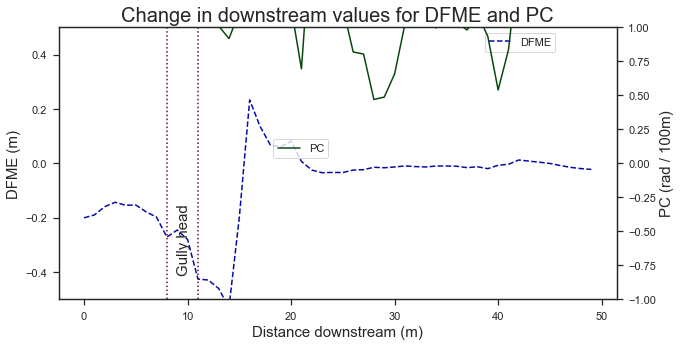

In [56]:
sns.set(style = 'ticks')
fig, ax1 = plt.subplots(figsize = (10, 5))
sns.lineplot(data = drainage_parameters_transpose,x = "Distance",y = "DFME", color = 'xkcd:cobalt blue')
ax1.set_ylabel('DFME (m)', fontsize=15)
ax1.lines[0].set_linestyle("--")
ax1.set_ylim(-0.5, 0.5)
ax1.set_xlabel('Distance downstream (m)', fontsize = 15)
ax1.legend(['DFME'],bbox_to_anchor=(0.4, 0.6, 0.5, 0.4))
ax2 = ax1.twinx()
ax2.set_ylim(-1, 1)
sns.lineplot(data=drainage_parameters_transpose,x = "Distance",y="Area",color='xkcd:forest green',ax = ax2)
ax2.set_ylabel('PC (rad / 100m)', fontsize = 15)
ax2.legend(['PC'],bbox_to_anchor=(0.375, 0.5, 0.5, 0.4))
plt.axvline(x=8, color = 'xkcd:merlot', linestyle = 'dotted')
plt.axvline(x=11, color = 'xkcd:merlot', linestyle = 'dotted')
ax1.text(9, -0.4, r'Gully head', fontsize=15, rotation = 90)
plt.title('Change in downstream values for DFME and PC', fontsize = 20)

Text(0.5, 1.0, 'Change in downstream values for DFME and PC')

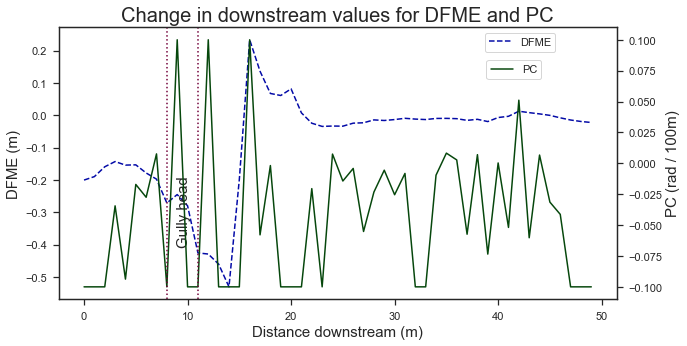

In [61]:
sns.set(style = 'ticks')
fig, ax1 = plt.subplots(figsize = (10, 5))
sns.lineplot(data = drainage_parameters_transpose,x = "Distance",y = "DFME", color = 'xkcd:cobalt blue')
ax1.set_ylabel('DFME (m)', fontsize=15)
ax1.lines[0].set_linestyle("--")
#ax1.set_ylim(-0.5, 0.5)
ax1.set_xlabel('Distance downstream (m)', fontsize = 15)
ax1.legend(['DFME'],bbox_to_anchor=(0.4, 0.6, 0.5, 0.4))
ax2 = ax1.twinx()
#ax2.set_ylim(-0.2, 0.2)
sns.lineplot(data=drainage_parameters_transpose,x = "Distance",y="PC",color='xkcd:forest green',ax = ax2)
ax2.set_ylabel('PC (rad / 100m)', fontsize = 15)
ax2.legend(['PC'],bbox_to_anchor=(0.375, 0.5, 0.5, 0.4))
plt.axvline(x=8, color = 'xkcd:merlot', linestyle = 'dotted')
plt.axvline(x=11, color = 'xkcd:merlot', linestyle = 'dotted')
ax1.text(9, -0.4, r'Gully head', fontsize=15, rotation = 90)
plt.title('Change in downstream values for DFME and PC', fontsize = 20)

Text(0.5, 1.0, 'Cumulative sum downstream values for DFME and PC')

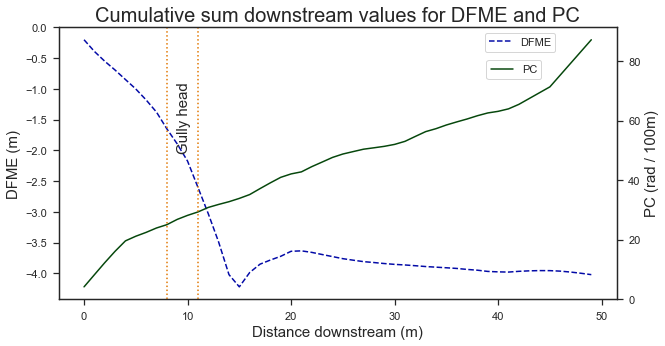

In [62]:
sns.set(style = 'ticks')
fig, ax1 = plt.subplots(figsize = (10, 5))
sns.lineplot(data = drainage_parameters_transpose, x = "Distance", y = "Cumulative DFME", color = 'xkcd:cobalt blue')
ax1.set_ylabel('DFME (m)', fontsize=15)
ax1.lines[0].set_linestyle("--")
#ax1.set_ylim(-2.5, 0.2)
ax1.set_xlabel('Distance downstream (m)', fontsize = 15)
ax1.legend(['DFME'],bbox_to_anchor=(0.4, 0.6, 0.5, 0.4))
ax2 = ax1.twinx()
#ax2.set_ylim(-2, 0.1)
sns.lineplot(data = drainage_parameters_transpose, x = "Distance", y = "Cumulative A", color = 'xkcd:forest green', ax = ax2)
ax2.set_ylabel('PC (rad / 100m)', fontsize = 15)
ax2.legend(['PC'],bbox_to_anchor=(0.375, 0.5, 0.5, 0.4))
plt.axvline(x=8, color = 'xkcd:pumpkin', linestyle = 'dotted')
plt.axvline(x=11, color = 'xkcd:pumpkin', linestyle = 'dotted')
ax1.text(9, -2, r'Gully head', fontsize=15, rotation = 90)
plt.title('Cumulative sum downstream values for DFME and PC', fontsize = 20)

Text(0.5, 1.0, 'Cumulative sum downstream values for DFME and PC')

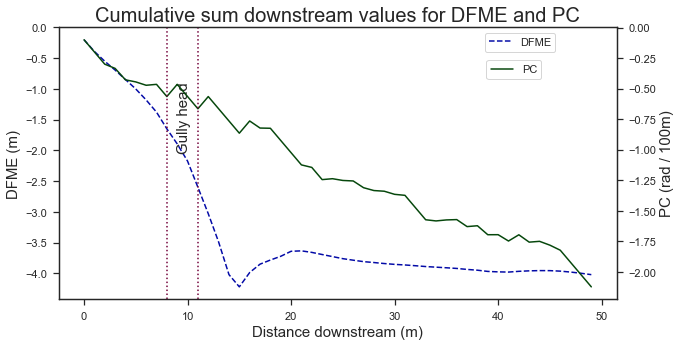

In [63]:
sns.set(style = 'ticks')
fig, ax1 = plt.subplots(figsize = (10, 5))
sns.lineplot(data = drainage_parameters_transpose, x = "Distance", y = "Cumulative DFME", color = 'xkcd:cobalt blue')
ax1.set_ylabel('DFME (m)', fontsize=15)
ax1.lines[0].set_linestyle("--")
#ax1.set_ylim(-2.5, 0.2)
ax1.set_xlabel('Distance downstream (m)', fontsize = 15)
ax1.legend(['DFME'],bbox_to_anchor=(0.4, 0.6, 0.5, 0.4))
ax2 = ax1.twinx()
#ax2.set_ylim(-2, 0.1)
sns.lineplot(data = drainage_parameters_transpose, x = "Distance", y = "Cumulative PC", color = 'xkcd:forest green', ax = ax2)
ax2.set_ylabel('PC (rad / 100m)', fontsize = 15)
ax2.legend(['PC'],bbox_to_anchor=(0.375, 0.5, 0.5, 0.4))
plt.axvline(x=8, color = 'xkcd:merlot', linestyle = 'dotted')
plt.axvline(x=11, color = 'xkcd:merlot', linestyle = 'dotted')
ax1.text(9, -2, r'Gully head', fontsize=15, rotation = 90)
plt.title('Cumulative sum downstream values for DFME and PC', fontsize = 20)

In [64]:
cumulative_dfme = drainage_parameters_transpose.loc[:,'Cumulative DFME'].values
dCDFMEdx = np.gradient(cumulative_dfme)
d2CDFMEdx2 = np.gradient(dCDFMEdx)

cumulative_pc = drainage_parameters_transpose.loc[:,'Cumulative PC'].values
dCPCdx = np.gradient(cumulative_pc)
d2CPCdx2 = np.gradient(dCPCdx)

cumulative_s = drainage_parameters_transpose.loc[:,'Cumulative S'].values
dCSdx = np.gradient(cumulative_s)
d2CSdx2 = np.gradient(dCSdx)

cumulative_a = drainage_parameters_transpose.loc[:,'Cumulative A'].values
dCAdx = np.gradient(cumulative_a)
d2CAdx2 = np.gradient(dCAdx)

drainage_parameters_transpose['dCDFMEdx'] = dCDFMEdx
drainage_parameters_transpose['dCPCdx'] = dCPCdx
drainage_parameters_transpose['dCSdx'] = dCSdx
drainage_parameters_transpose['dCAdx'] = dCAdx

drainage_parameters_transpose['d2CDFMEdx2'] = d2CDFMEdx2
drainage_parameters_transpose['d2CPCdx2'] = d2CPCdx2
drainage_parameters_transpose['d2CSdx2'] = d2CSdx2
drainage_parameters_transpose['d2CAdx2'] = d2CAdx2

In [65]:
drainage_parameters_transpose_spline = pd.DataFrame(np.arange(0,200)/4.0, columns = ['Distance']) 

In [66]:
spline_smoothness = np.linspace(0,49, 200)
spline_input_distance = drainage_parameters_transpose.loc[:,'Distance'].values

spline_input_dfme = drainage_parameters_transpose.loc[:,'DFME'].values
dfme_spline_setup = InterpolatedUnivariateSpline(spline_input_distance, spline_input_dfme)
dfme_spline = dfme_spline_setup(spline_smoothness)

spline_input_pc = drainage_parameters_transpose.loc[:,'PC'].values
pc_spline_setup = InterpolatedUnivariateSpline(spline_input_distance, spline_input_pc)
pc_spline = pc_spline_setup(spline_smoothness)

spline_input_slope = drainage_parameters_transpose.loc[:,'Slope'].values
slope_spline_setup = InterpolatedUnivariateSpline(spline_input_distance, spline_input_slope)
slope_spline = slope_spline_setup(spline_smoothness)

spline_input_area = drainage_parameters_transpose.loc[:,'Area'].values
area_spline_setup = InterpolatedUnivariateSpline(spline_input_distance, spline_input_area)
area_spline = area_spline_setup(spline_smoothness)

spline_input_d2CDFMEdx2 = drainage_parameters_transpose.loc[:,'d2CDFMEdx2'].values
d2CDFMEdx2_spline_setup = InterpolatedUnivariateSpline(spline_input_distance, spline_input_d2CDFMEdx2)
d2CDFMEdx2_spline = d2CDFMEdx2_spline_setup(spline_smoothness)

spline_input_d2CPCdx2 = drainage_parameters_transpose.loc[:,'d2CPCdx2'].values
d2CPCdx2_spline_setup = InterpolatedUnivariateSpline(spline_input_distance, spline_input_d2CPCdx2)
d2CPCdx2_spline = d2CPCdx2_spline_setup(spline_smoothness)

spline_input_dCDFMEdx = drainage_parameters_transpose.loc[:,'dCDFMEdx'].values
dCDFMEdx_spline_setup = InterpolatedUnivariateSpline(spline_input_distance, spline_input_dCDFMEdx)
dCDFMEdx_spline = dCDFMEdx_spline_setup(spline_smoothness)

spline_input_dCPCdx = drainage_parameters_transpose.loc[:,'dCPCdx'].values
dCPCdx_spline_setup = InterpolatedUnivariateSpline(spline_input_distance, spline_input_dCPCdx)
dCPCdx_spline = dCPCdx_spline_setup(spline_smoothness)

drainage_parameters_transpose_spline['DFME Spline'] = dfme_spline
drainage_parameters_transpose_spline['PC Spline'] = pc_spline
drainage_parameters_transpose_spline['d2CDFMEdx2 Spline'] = d2CDFMEdx2_spline
drainage_parameters_transpose_spline['d2CPCdx2 Spline'] = d2CPCdx2_spline
drainage_parameters_transpose_spline['dCDFMEdx Spline'] = dCDFMEdx_spline
drainage_parameters_transpose_spline['dCPCdx Spline'] = dCPCdx_spline

# Possible rules
1. Find peak in second derivative of DFME and then the first point it cross the x-axis.
2. Find point that PC goes from large negative to positive and then point that it crosses x-axis.
3. Some combination of 1 & 2. E.g. condition 1 only if first part of condition 2 is also met.

Probably just the first is best but can still talk about considering PC and show graph.

Text(0.5, 1.0, 'DFME and PC upstream')

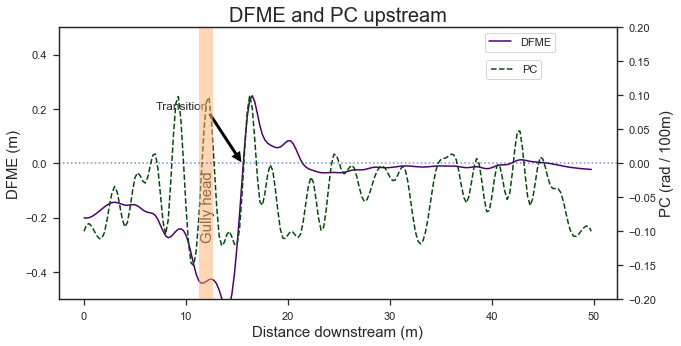

In [67]:
sns.set(style = 'ticks')
fig, ax1 = plt.subplots(figsize = (10, 5))
sns.lineplot(data = drainage_parameters_transpose_spline, x = "Distance", y = "DFME Spline", 
             color = 'xkcd:royal purple')
ax1.set_ylabel('DFME (m)', fontsize=15)
ax1.annotate('Transition', arrowprops = dict(facecolor = 'black'), xy = (15.5, 0), xytext = (7, 0.2))
#ax1.lines[0].set_linestyle("--")
ax1.set_ylim(-0.5, 0.5)
ax1.set_xlabel('Distance downstream (m)', fontsize = 15)
ax1.legend(['DFME'],bbox_to_anchor=(0.4, 0.6, 0.5, 0.4))
ax2 = ax1.twinx()
ax2.set_ylim(-0.2, 0.2)
sns.lineplot(data = drainage_parameters_transpose_spline, x = "Distance", y = "PC Spline", color = 'xkcd:forest green', ax = ax2)
ax2.lines[0].set_linestyle("--")
ax2.set_ylabel('PC (rad / 100m)', fontsize = 15)
ax2.legend(['PC'],bbox_to_anchor=(0.375, 0.5, 0.5, 0.4))
plt.axvline(x=12, color = 'xkcd:apricot', linewidth = 14, alpha = 0.5)
plt.axhline(y=0, color = 'xkcd:cobalt blue', alpha = 0.5, linestyle = 'dotted')
#plt.axvline(x=11, color = 'xkcd:pumpkin', linestyle = 'dotted')
ax1.text(11.5, -0.28, r'Gully head', fontsize=15, rotation = 90)
plt.title('DFME and PC upstream', fontsize = 20)

## Second derivative works best because the highest rate is the middle of the wall going up and the point that then crosses the x-axis when the increase stops being positive (immediately after passing up over the edge of the gully) - straight from graph theory. 

## First derivative.

Text(0.5, 1.0, 'Second derivative of DFME and PC cumulative upstream sum')

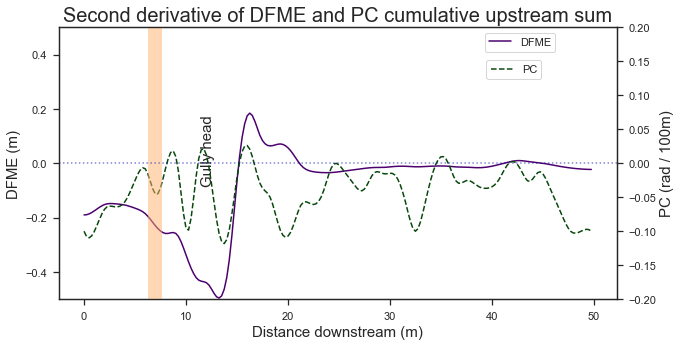

In [68]:
sns.set(style = 'ticks')
fig, ax1 = plt.subplots(figsize = (10, 5))
sns.lineplot(data = drainage_parameters_transpose_spline, x = "Distance", y = "dCDFMEdx Spline", 
             color = 'xkcd:royal purple')
ax1.set_ylabel('DFME (m)', fontsize=15)
#ax1.annotate('Transition', arrowprops = dict(facecolor = 'black'), xy = (15.5, 0), xytext = (7, 0.06))
#ax1.lines[0].set_linestyle("--")
ax1.set_ylim(-0.5, 0.5)
ax1.set_xlabel('Distance downstream (m)', fontsize = 15)
ax1.legend(['DFME'],bbox_to_anchor=(0.4, 0.6, 0.5, 0.4))
ax2 = ax1.twinx()
ax2.set_ylim(-0.2, 0.2)
sns.lineplot(data = drainage_parameters_transpose_spline, x = "Distance", y = "dCPCdx Spline", 
             color = 'xkcd:forest green', ax = ax2)
ax2.lines[0].set_linestyle("--")
ax2.set_ylabel('PC (rad / 100m)', fontsize = 15)
ax2.legend(['PC'],bbox_to_anchor=(0.375, 0.5, 0.5, 0.4))
plt.axvline(x=7, color = 'xkcd:apricot', linewidth = 14, alpha = 0.5)
plt.axhline(y=0, color = 'xkcd:cobalt blue', alpha = 0.5, linestyle = 'dotted')
#plt.axvline(x=6.5, color = 'xkcd:pumpkin', linestyle = 'dotted')
ax1.text(11.5, -0.075, r'Gully head', fontsize=15, rotation = 90)
plt.title('Second derivative of DFME and PC cumulative upstream sum', fontsize = 20)

Text(0.5, 1.0, 'Second derivative of DFME and PC cumulative upstream sum')

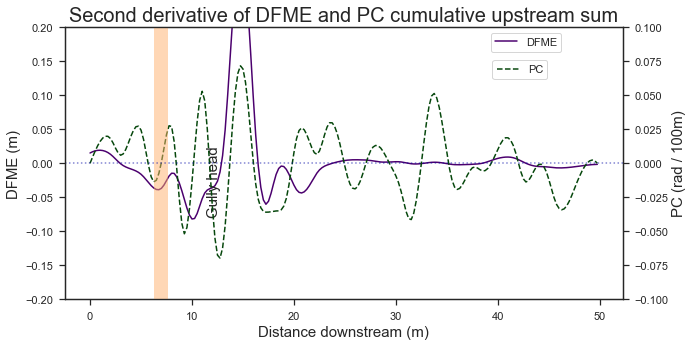

In [69]:
sns.set(style = 'ticks')
fig, ax1 = plt.subplots(figsize = (10, 5))
sns.lineplot(data = drainage_parameters_transpose_spline, x = "Distance", y = "d2CDFMEdx2 Spline", 
             color = 'xkcd:royal purple')
ax1.set_ylabel('DFME (m)', fontsize=15)
#ax1.annotate('Transition', arrowprops = dict(facecolor = 'black'), xy = (15.5, 0), xytext = (7, 0.06))
#ax1.lines[0].set_linestyle("--")
ax1.set_ylim(-0.2, 0.2)
ax1.set_xlabel('Distance downstream (m)', fontsize = 15)
ax1.legend(['DFME'],bbox_to_anchor=(0.4, 0.6, 0.5, 0.4))
ax2 = ax1.twinx()
ax2.set_ylim(-0.1, 0.1)
sns.lineplot(data = drainage_parameters_transpose_spline, x = "Distance", y = "d2CPCdx2 Spline", 
             color = 'xkcd:forest green', ax = ax2)
ax2.lines[0].set_linestyle("--")
ax2.set_ylabel('PC (rad / 100m)', fontsize = 15)
ax2.legend(['PC'],bbox_to_anchor=(0.375, 0.5, 0.5, 0.4))
plt.axvline(x=7, color = 'xkcd:apricot', linewidth = 14, alpha = 0.5)
plt.axhline(y=0, color = 'xkcd:cobalt blue', alpha = 0.5, linestyle = 'dotted')
#plt.axvline(x=6.5, color = 'xkcd:pumpkin', linestyle = 'dotted')
ax1.text(11.5, -0.075, r'Gully head', fontsize=15, rotation = 90)
plt.title('Second derivative of DFME and PC cumulative upstream sum', fontsize = 20)

In [70]:
def np_array_to_Geotiff(newfile, original_tiff, np_array, dtype):
    
    cols = np_array.shape[1]
    rows = np_array.shape[0]
    originX, pixelWidth, b, originY, d, pixelHeight = original_tiff.GetGeoTransform() 
    driver = gdal.GetDriverByName('GTiff')
    GDT_dtype = gdal.GDT_Unknown
    if dtype == "Float64": 
        GDT_dtype = gdal.GDT_Float64
    elif dtype == "Float32":
        GDT_dtype = gdal.GDT_Float32
    else:
        print("Not supported data type.")
    
    if np_array.ndim == 2:
        band_num = 1
    else:
        band_num = np_array.shape[2]

    outRaster = driver.Create(newfile, cols, rows, band_num, GDT_dtype)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    
    # Loop over all bands.
    for b in range(band_num):
        outband = outRaster.GetRasterBand(b + 1)
    
        # Read in the band's data into the third dimension of our array
        if band_num == 1:
            outband.WriteArray(np_array)
        else:
            outband.WriteArray(np_array[:,:,b])

    # setteing srs from input tif file.
    prj=original_tiff.GetProjection()
    outRasterSRS = osr.SpatialReference(wkt=prj)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()
    outRaster = None
    
    return outRaster

In [ ]:
np_array_to_Geotiff('af_2_sub_fw.tif', input_geotiff, flow_width, drainage_area.dtype)